In [1]:
#Импорты
from random import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

r_seed = np.random.seed(0)

# Первичный анализ данных

In [2]:
data_full = pd.read_excel(r'Задание (пролонгация).xlsx',
                          sheet_name='data_full')

In [3]:
data_full.head(3)

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,NaN,TOYOTA,RAV 4,2018,Нет,Состоит в браке,...,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,NaN,LADA,GRANTA,2016,Нет,Состоит в браке,...,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,NaN,LADA,GRANTA,2018,Нет,Не состоит в браке,...,49,20,0.95,400000,F,0,30000,0.065,1,1


##### Рассмотрим типы объектов в колонках

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10863 non-null  int64  
 1   Filial           10863 non-null  object 
 2   Type_ts          10863 non-null  object 
 3   passport_region  10863 non-null  object 
 4   VIP              284 non-null    object 
 5   Brand            10863 non-null  object 
 6   Model            10863 non-null  object 
 7   Yr_production    10863 non-null  int64  
 8   GAP              10863 non-null  object 
 9   married          10863 non-null  object 
 10  KBM              10863 non-null  int64  
 11  KBM_prol_est     10863 non-null  int64  
 12  delta_kbm        10863 non-null  int64  
 13  deduct           10863 non-null  object 
 14  deduct_amount    10863 non-null  object 
 15  product          10863 non-null  object 
 16  Bank             10863 non-null  object 
 17  channel - ma

In [5]:
data_full['VIP'].loc[data_full['VIP'].notna()].unique()

array(['Особый статус +', 'Особый статус'], dtype=object)

##### В ходе анализа данных были обнаружены пропуски, пустые значения и несоответствие типов данных. Заменяем во всем датасете

In [6]:
data_full['VIP'] = data_full['VIP'].replace(np.nan, 'Без статуса')

In [7]:
data_full['VIP'].loc[data_full['VIP'].notna()].unique()

array(['Без статуса', 'Особый статус +', 'Особый статус'], dtype=object)

In [8]:
print(data_full['sex'].unique())
print(data_full.shape)
data_full.drop(data_full[data_full['sex'] == ' '].index, inplace=True)
data_full.drop(data_full[data_full['passport_region'] == 'н.д.'].index,
               inplace=True)
print(data_full.shape)

['M' 'F' ' ']
(10863, 30)
(10851, 30)


In [9]:
data_full['Model'] = data_full['Model'].astype(str)

##### Выделяем категориальные и вещественные признаки

In [10]:
data_cat = data_full.select_dtypes(include='object')
data_num = data_full.select_dtypes(include=['int64', 'float64'])
data_num = data_num.drop('ID', axis=1)

In [11]:
data_num.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,2018,8,6,-2,42,24,1.00,1400000,0,55000,0.040,0,0
1,2016,8,6,-2,41,4,1.05,200000,0,10000,0.010,0,0
2,2018,8,6,-2,49,20,0.95,400000,0,30000,0.065,1,1


In [12]:
data_num.describe()

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
count,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,1.085100e+04,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000
mean,2016.940466,7.058704,5.196019,-5.060547,43.688508,17.248825,1.000101,9.769975e+05,0.087273,32804.349830,0.033305,0.586305,-0.082297
std,1.546977,1.922403,1.735667,17.259764,11.248181,9.601594,0.050595,6.776986e+05,0.282248,19662.623634,0.016959,0.492518,0.715819
min,2009.000000,0.000000,0.000000,-100.000000,18.000000,0.000000,0.900000,0.000000e+00,0.000000,10000.000000,0.000000,0.000000,-1.000000
25%,2016.000000,6.000000,5.000000,-2.000000,35.000000,10.000000,1.000000,6.000000e+05,0.000000,15000.000000,0.020000,0.000000,-1.000000
50%,2018.000000,8.000000,6.000000,-2.000000,42.000000,16.000000,1.000000,8.000000e+05,0.000000,30000.000000,0.030000,1.000000,0.000000
75%,2018.000000,8.000000,6.000000,-2.000000,52.000000,22.000000,1.000000,1.200000e+06,0.000000,45000.000000,0.045000,1.000000,0.000000
max,2018.000000,12.000000,10.000000,2.000000,84.000000,63.000000,1.100000,3.000000e+06,1.000000,70000.000000,0.100000,1.000000,1.000000


##### Часть вещественных признаков переносим в категориальные

In [13]:
possible_cats = ['KBM', 'KBM_prol_est', 'premium_car',
                 'discount', 'OSAGO_clnt', 'delta_kbm']
for category in possible_cats:
    print(f'Уникальные значения {category} - {data_full[category].unique()}')

Уникальные значения KBM - [ 8  6  0  2  4  1  5  7  9  3 12 10 11]
Уникальные значения KBM_prol_est - [ 6  4  0  5  2  7  3  9  1  8 10]
Уникальные значения premium_car - [0 1]
Уникальные значения discount - [1.   1.05 0.95 1.1  0.9 ]
Уникальные значения OSAGO_clnt - [0 1]
Уникальные значения delta_kbm - [  -2 -100   -1    1    0    2]


In [14]:
pd.concat([data_cat, data_num['OSAGO_clnt'], data_num['premium_car']], axis=1)
data_num = data_num.drop(['OSAGO_clnt', 'premium_car'], axis=1)

In [15]:
data_cat.head(3)

,Filial,Type_ts,passport_region,VIP,Brand,Model,GAP,married,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,sex
0,Магнитогорский,Иностранные,Челябинская область,Без статуса,TOYOTA,RAV 4,Нет,Состоит в браке,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M
1,Магнитогорский,Отечественные,Челябинская область,Без статуса,LADA,GRANTA,Нет,Состоит в браке,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,M
2,Ростовский,Отечественные,Ростовская область,Без статуса,LADA,GRANTA,Нет,Не состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,F


In [16]:
data_cat.describe(include='all')

,Filial,Type_ts,passport_region,VIP,Brand,Model,GAP,married,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,sex
count,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851,10851
unique,22,2,84,3,23,200,2,2,3,3,4,3,2,4,2,2
top,Московский,Иностранные,Москва,Без статуса,LADA,RIO,Нет,Состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M
freq,3304,8344,1611,10568,2176,914,9740,8485,7141,7141,7694,5829,8404,6072,10745,7180


In [17]:
pd.options.mode.chained_assignment = None
data_cat[['OSAGO_clnt', 'premium_car', 'deduct_amount']] = data_full[[
    'OSAGO_clnt', 'premium_car', 'deduct_amount']].astype(str)

data_full[['OSAGO_clnt', 'premium_car', 'deduct_amount']] = data_full[[
    'OSAGO_clnt', 'premium_car', 'deduct_amount']].astype(str)
data_full['VIP'].value_counts().index

Index(['Без статуса', 'Особый статус +', 'Особый статус'], dtype='object')

##### Выделяем тестовые данные для дальнейшего использования

In [18]:
data_train = data_full[(data_full['target'] == 1) | (data_full['target'] == 0)]
data_train

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,Без статуса,TOYOTA,RAV 4,2018,Нет,Состоит в браке,...,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,Без статуса,LADA,GRANTA,2016,Нет,Состоит в браке,...,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,Без статуса,LADA,GRANTA,2018,Нет,Не состоит в браке,...,49,20,0.95,400000,F,0,30000,0.065,1,1
3,4,Казанский,Иностранные,Республика Татарстан,Без статуса,KIA,RIO,2016,Нет,Не состоит в браке,...,40,15,1.10,400000,M,0,10000,0.020,1,0
4,5,Московский,Иностранные,Москва,Без статуса,DATSUN,ON-DO,2018,Нет,Состоит в браке,...,58,23,1.00,400000,M,0,10000,0.015,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,7594,Санкт - Петербургский,Отечественные,Ленинградская область,Без статуса,LADA,LARGUS,2018,Нет,Состоит в браке,...,40,10,1.00,600000,M,0,10000,0.010,0,0
7594,7595,Московский,Иностранные,Московская область,Без статуса,HYUNDAI,CRETA,2018,Нет,Состоит в браке,...,37,16,1.00,1000000,F,0,15000,0.010,0,0
7595,7596,Санкт - Петербургский,Иностранные,Санкт-Петербург,Без статуса,RENAULT,DUSTER,2018,Нет,Не состоит в браке,...,44,20,0.90,800000,M,0,45000,0.045,0,0
7596,7597,Ижевский,Отечественные,Удмуртская Республика,Без статуса,LADA,2121,2018,Нет,Не состоит в браке,...,34,15,1.00,400000,M,0,15000,0.030,1,0


In [19]:
data_1 = data_full[data_full['target'] == 1]
data_0 = data_full[data_full['target'] == 0]

In [20]:
data_1['product'].value_counts()

Классика     1632
Компакт       517
Уверенный     221
Name: product, dtype: int64

# Анализ категориальных признаков

##### Создаем функцию для визуализации категориальных признаков

In [21]:
def cat_plot(col_list, height=1, width=1, figsize=(20, 35),
             sharey=False, title='Распределение категориальных признаков',
             data_1=data_1, data_0=data_0, h_bars=[], long_labels=[]):

    fig, axes = plt.subplots(height, width, figsize=figsize, sharey=sharey)
    if (height > 1) or (width > 1):
        axes = axes.ravel()
    else:
        axes = [axes]

    fig.suptitle(title, y=0.92,
                 fontsize=18, fontweight='bold')

    for ax, cat_col in zip(axes, col_list):

        val_1 = data_1[cat_col].value_counts()
        val_0 = data_0[cat_col].value_counts()

        if cat_col in h_bars:

            hbars_0 = ax.barh(width=val_0,
                              y=range(len(val_0.index)),
                              color='royalblue',
                              alpha=0.8,
                              label='Не пролонгирован')

            hbars_1 = ax.barh(width=val_1,
                              y=range(len(val_1.index)),
                              color='darkgray',
                              label='Пролонгирован')
            ax.set_ylim(bottom=-1, top=len(val_0.index))

            for bar_1, bar_0 in zip(hbars_1, hbars_0):
                x_val1 = bar_1.get_width()
                y_val1 = bar_1.get_y()
                x_val0 = bar_0.get_width()
                y_val0 = bar_0.get_y()

                ax.text(x_val1*1.01,
                        y_val1,
                        x_val1,
                        color='black',
                        fontweight='bold')

                ax.text(x_val0+3,
                        y_val0,
                        f"{x_val0}({(x_val1/(x_val1+x_val0)*100):.1f}%)",
                        color='darkblue',
                        fontweight='bold')
            ax.set_yticks(range(len(val_0.index)))
            ax.set_yticklabels(list(val_0.index))

        else:

            bars_0 = ax.bar(height=val_0,
                            x=range(len(val_0.index)),
                            color='royalblue',
                            alpha=0.8,
                            label='Не пролонгирован')

            bars_1 = ax.bar(height=val_1,
                            x=range(len(val_1.index)),
                            color='darkgray',
                            label='Пролонгирован')

            ax.set_xticks(range(len(val_0.index)))

            if cat_col in long_labels:
                ax.set_xticklabels(list(val_0.index), rotation=-15, ha='left')
            else:
                ax.set_xticklabels(list(val_0.index))

            for bar_1, bar_0 in zip(bars_1, bars_0):

                y_val1 = bar_1.get_height()
                y_val0 = bar_0.get_height()

                ax.text(bar_1.get_x()+0.45*bar_1.get_width(),
                        y_val1 * 1.03,
                        y_val1,
                        color='black',
                        fontweight='bold')

                ax.text(bar_0.get_x(),
                        y_val0 * 1.01,
                        y_val0,
                        color='darkblue',
                        fontweight='bold')
                if (y_val1 + y_val0)/(len(data_1)+len(data_0)) > 0.025:
                    ax.text(bar_0.get_x(),
                            10,
                            f'({(y_val1/(y_val1+y_val0)*100):.1f}%)',
                            color='black',
                            fontweight='bold')
                else:
                    ax.text(bar_0.get_x(),
                            y_val0+ax.get_ylim()[1]*0.05,
                            f'({(y_val1/(y_val1+y_val0)*100):.1f}%)',
                            color='black',
                            fontweight='bold')

        ax.set_title(cat_col, fontsize=14, fontweight='bold')
        ax.legend(loc='upper right')

    for ax in axes[len(col_list):]:
        ax.remove()

    plt.show()

##### В скобках указан % пролонгации для каждого признака

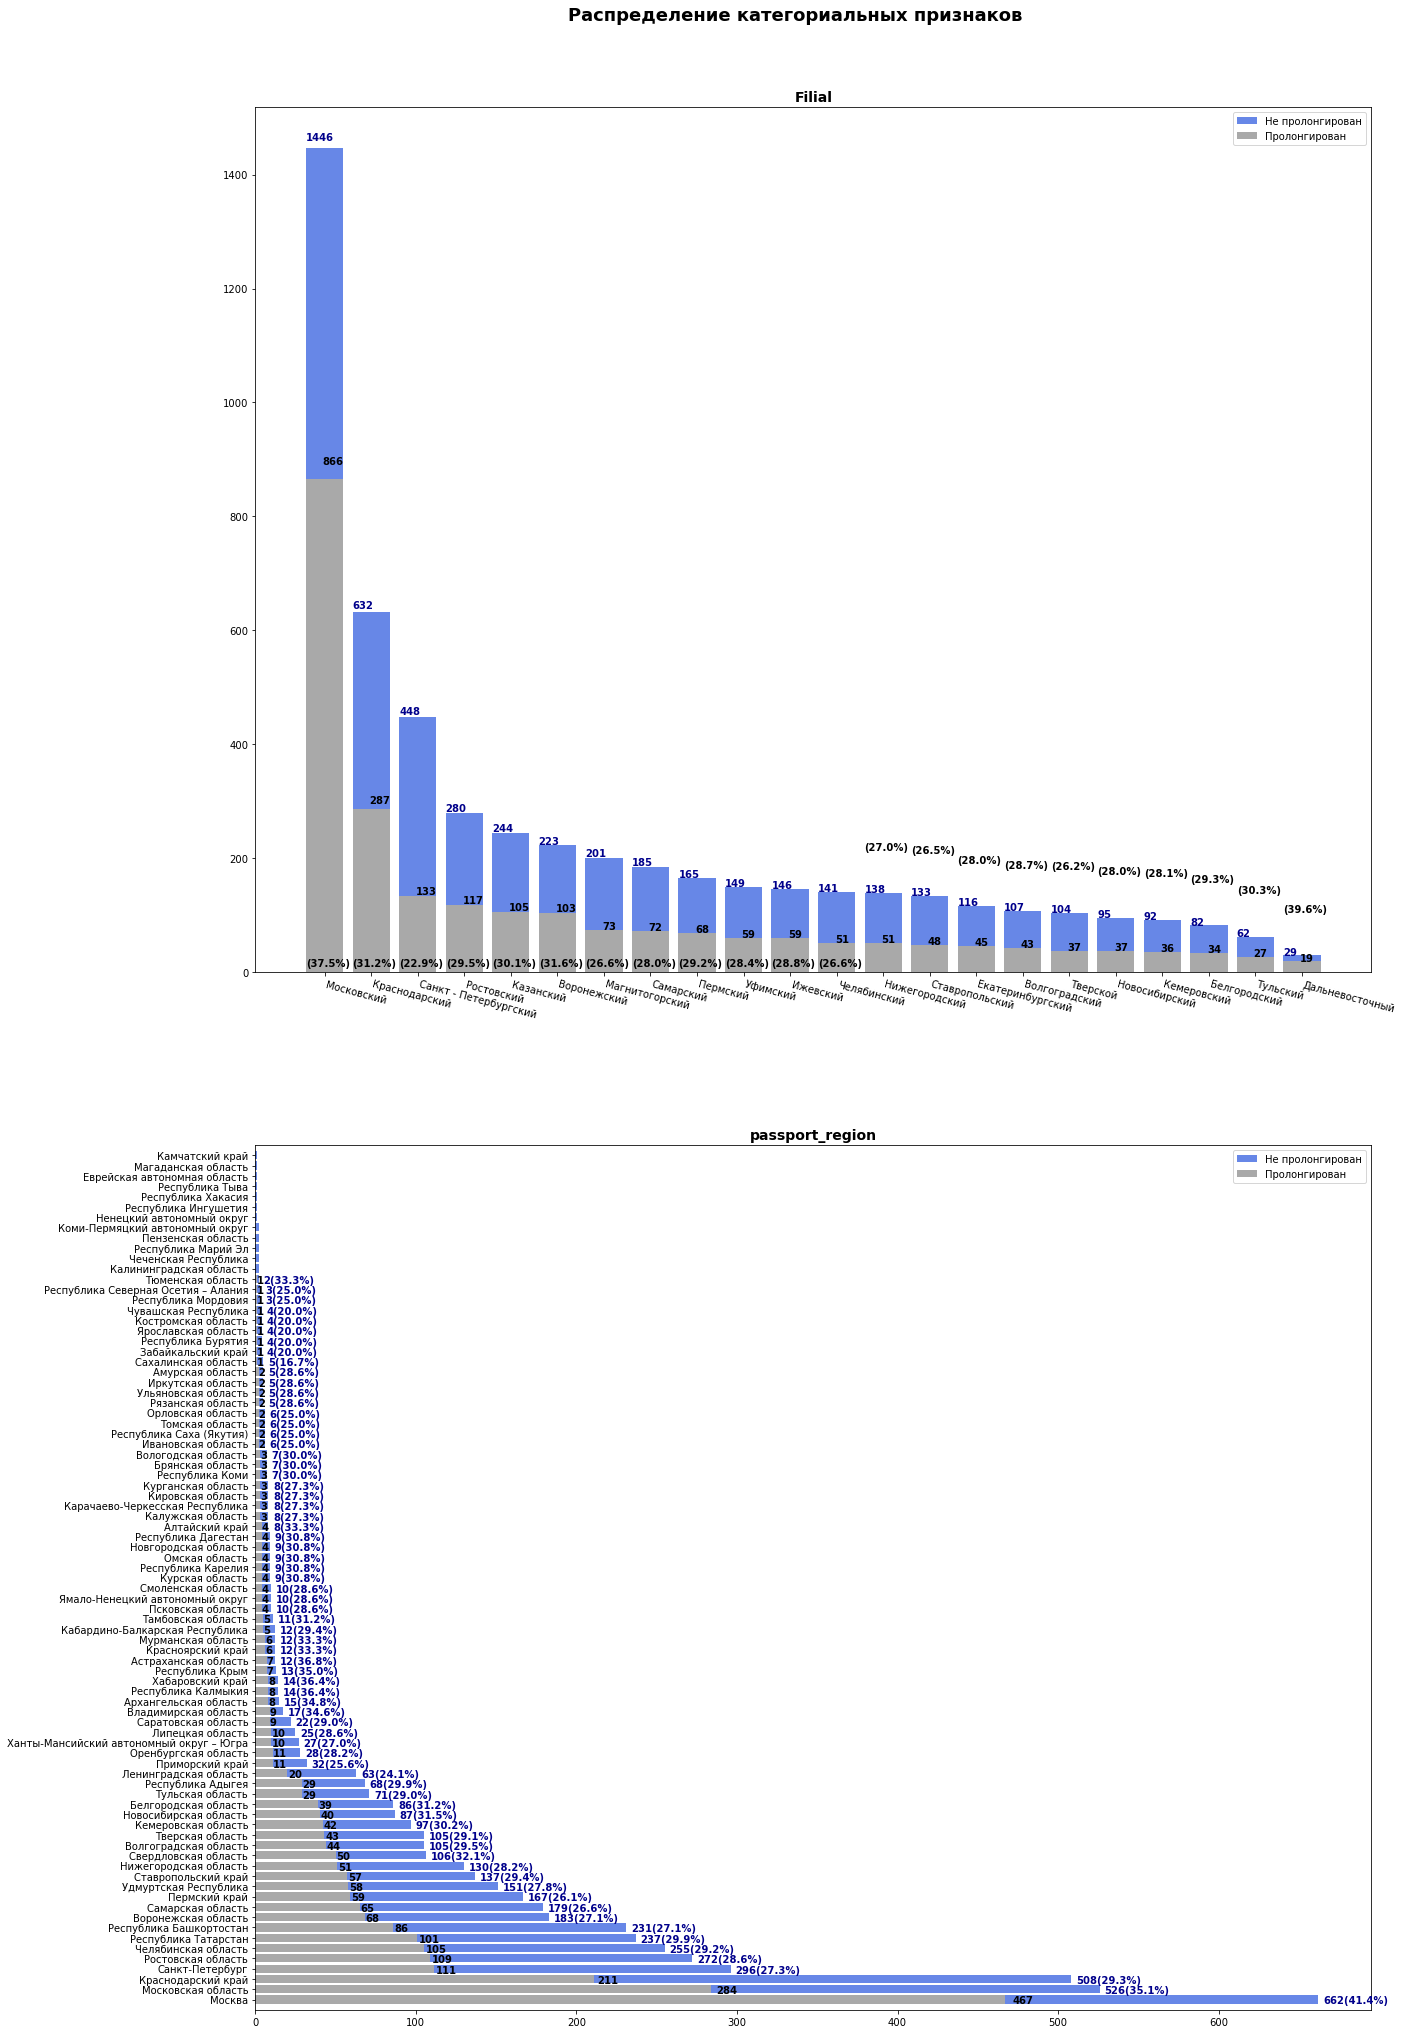

In [22]:
sub_cat = ['Filial', 'passport_region']
cat_plot(sub_cat, height=2, width=1, h_bars=['passport_region'], long_labels=['Filial'])

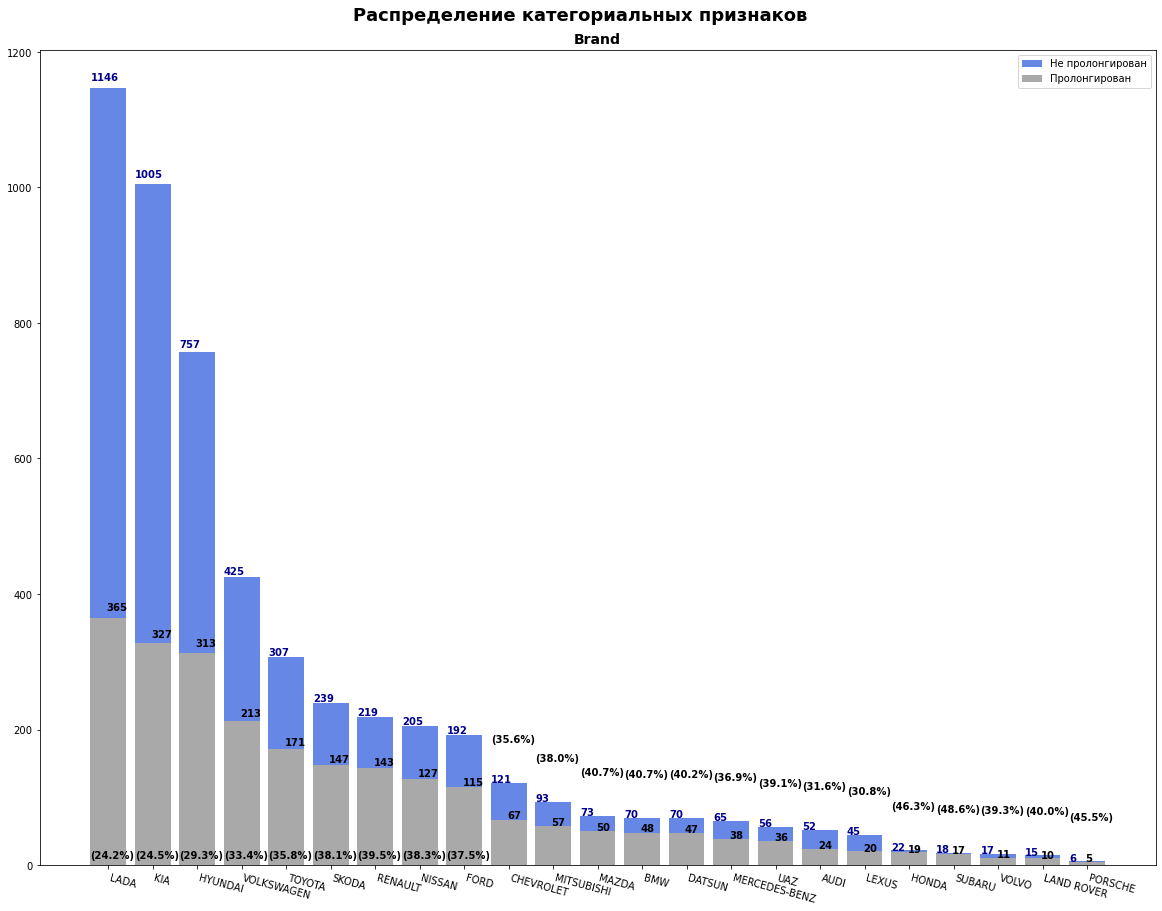

In [23]:
sub_cat = ['Brand']
cat_plot(sub_cat, height=1, width=1, long_labels=['Brand'], figsize=(20, 15))

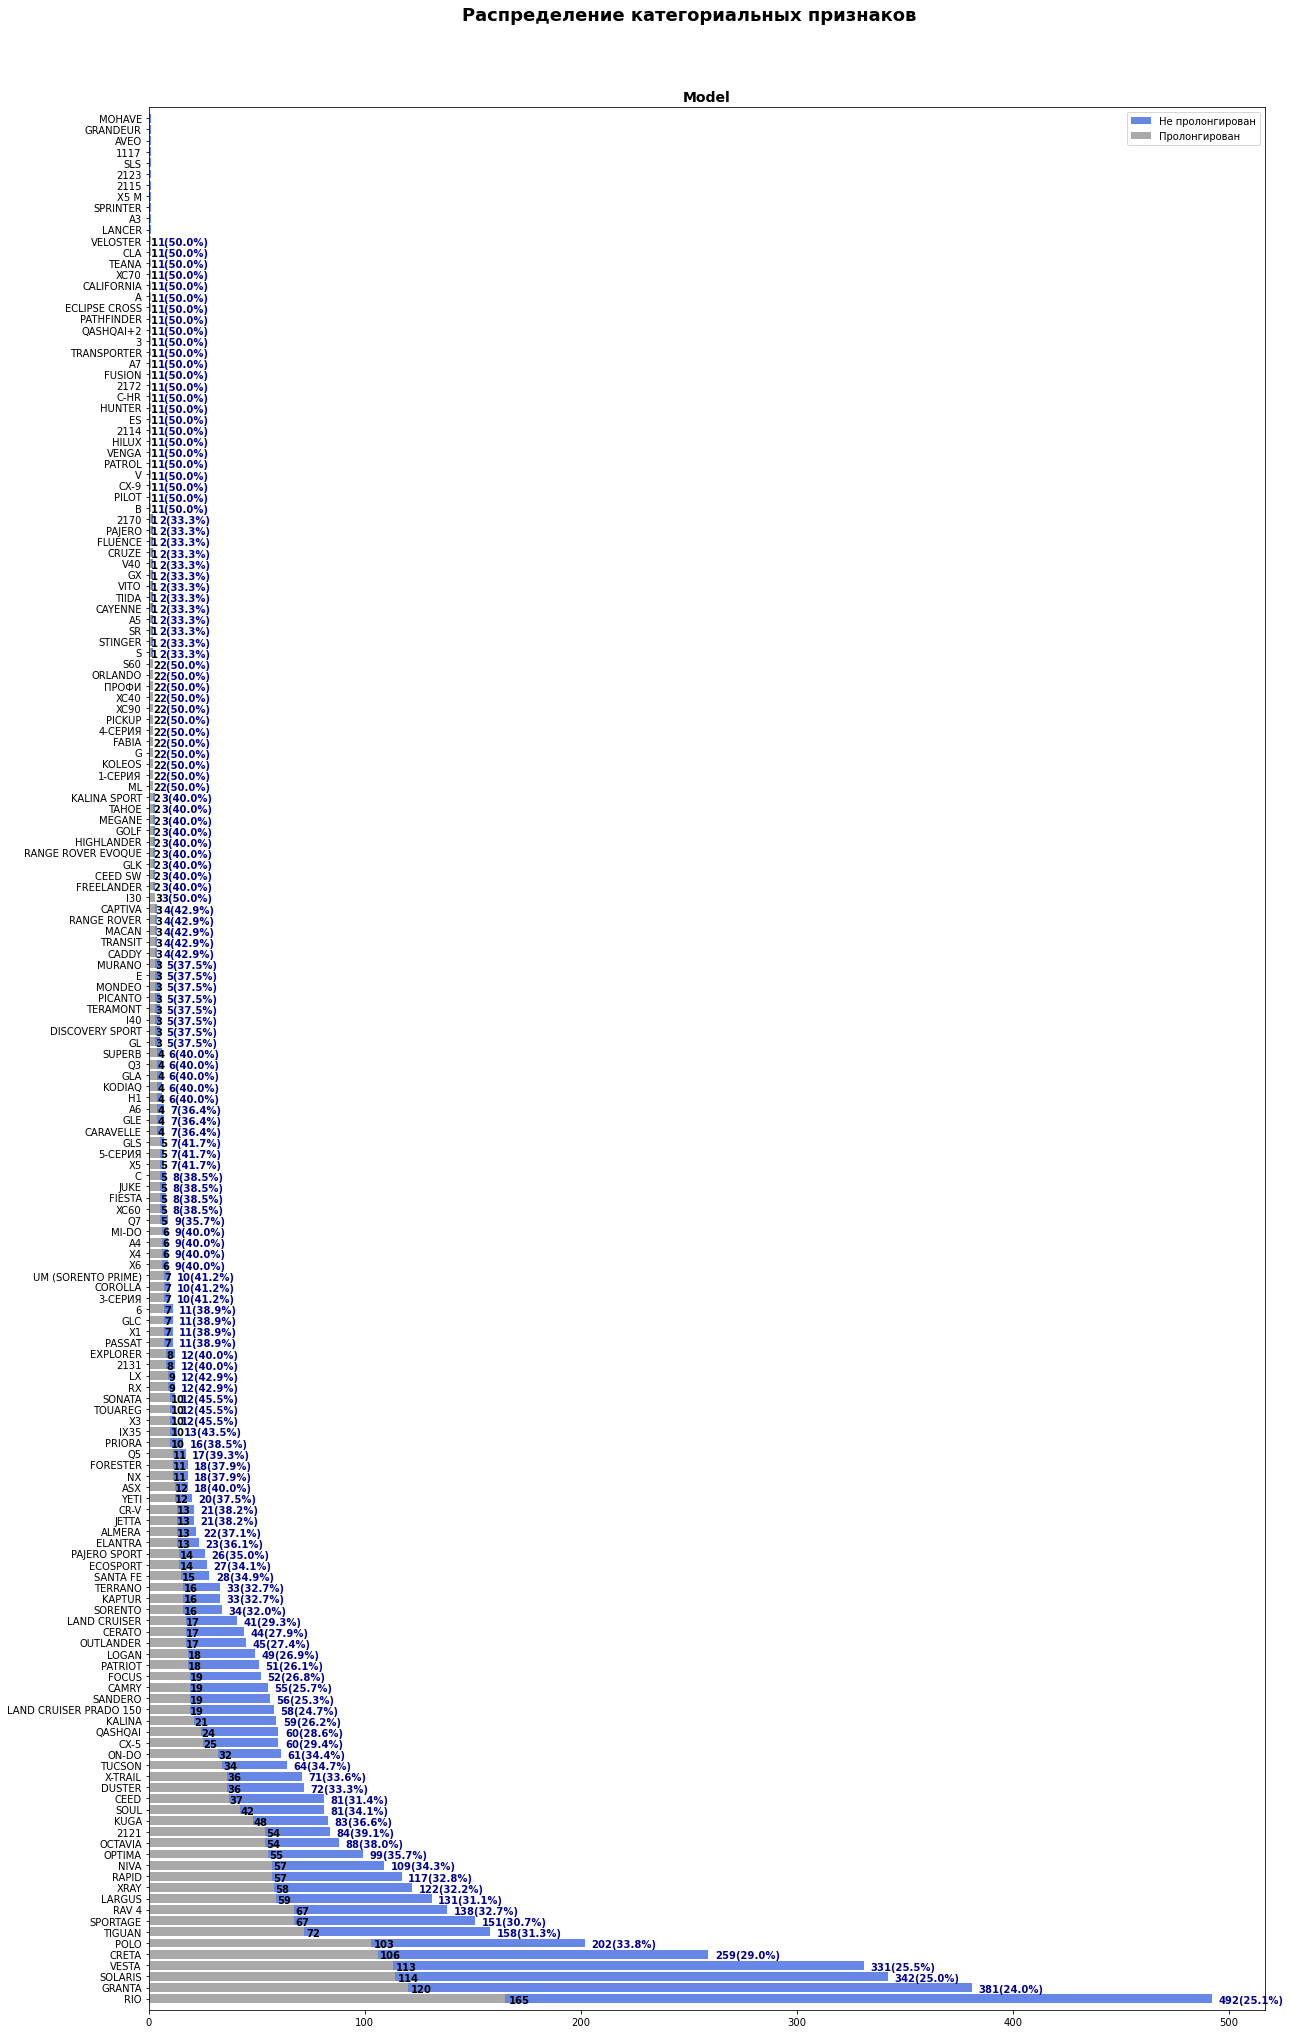

In [24]:
sub_cat = ['Model']
cat_plot(sub_cat, height=1, width=1, h_bars=['Model'], figsize=(20, 35))

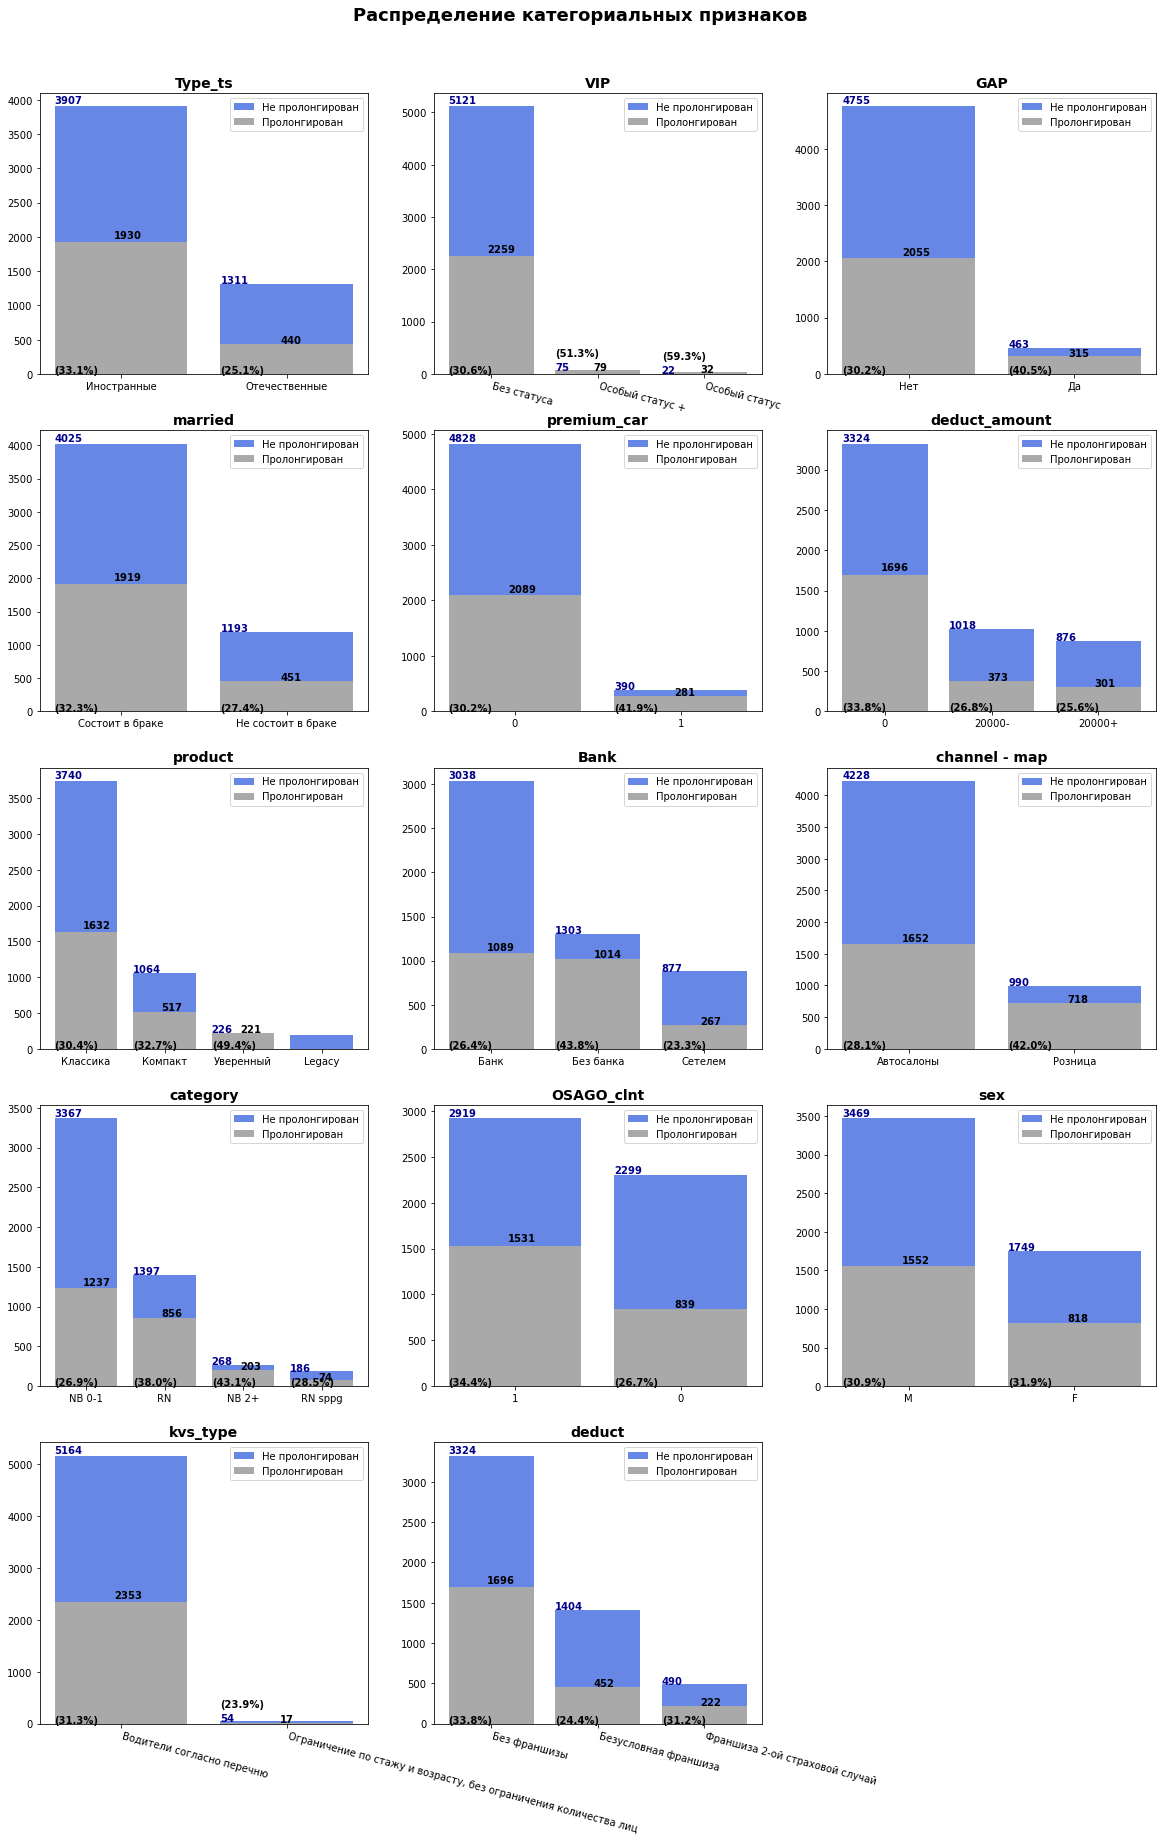

In [25]:
cat_cols = list(data_cat.columns)
sub_cat = [cat_cols[1], cat_cols[3]]
sub_cat.extend(cat_cols[6:])
sub_cat[4], sub_cat[10], sub_cat[-1], sub_cat[-2] = sub_cat[-1], sub_cat[-2], sub_cat[4], sub_cat[10]
cat_plot(sub_cat, height=5, width=3,
         long_labels=['VIP', 'deduct', 'kvs_type'], figsize=(20, 30))

##### По результатам анализа видно, что в выборке множество объектов с малой выборкой, для исключения их из предсказания делаем функцию для удаления объектов каждого класса с менее 10 элементами и оверсемплим объекты в диапазоне 10-99 штук до значения в 100 единиц

In [26]:
def oversampler(data, ovr_cols=[], min_val=10, ovr_val=100):
    print(f'Initial shape - {data.shape}')
    for col in ovr_cols:

        rare_values = data[col].value_counts().loc[lambda x: x < min_val].index
        
        for val in rare_values:
            data.drop(data[data[col] == val].index,
                      inplace=True)
        print(f'Shape after decreasing {col} - {data.shape}')
        
        count_model = data[col].value_counts().loc[\
            lambda x: (x >= min_val) & (x < ovr_val)]
        ovr_model = count_model.index
        
        for count, model in zip(count_model, ovr_model):
            indexes = data.loc[data[col] == model].index
            rand_ind = np.random.choice(indexes, size=ovr_val - count)
            data_rand = data.loc[rand_ind, :].copy()
            data = data.append(data_rand)
        print(f'Shape after upsampling {col} - {data.shape}')
    print('Process finished')
    return data

In [28]:
data_short = data_train.copy()

In [29]:
data_short = oversampler(data_short, ovr_cols=cat_cols)

Initial shape - (7588, 30)
Shape after decreasing Filial - (7588, 30)
Shape after upsampling Filial - (7641, 30)
Shape after decreasing Type_ts - (7641, 30)
Shape after upsampling Type_ts - (7641, 30)
Shape after decreasing passport_region - (7459, 30)
Shape after upsampling passport_region - (9666, 30)
Shape after decreasing VIP - (9666, 30)
Shape after upsampling VIP - (9724, 30)
Shape after decreasing Brand - (9724, 30)
Shape after upsampling Brand - (10240, 30)
Shape after decreasing Model - (9982, 30)
Shape after upsampling Model - (28695, 30)
Shape after decreasing GAP - (28695, 30)
Shape after upsampling GAP - (28695, 30)
Shape after decreasing married - (28695, 30)
Shape after upsampling married - (28695, 30)
Shape after decreasing deduct - (28695, 30)
Shape after upsampling deduct - (28695, 30)
Shape after decreasing deduct_amount - (28695, 30)
Shape after upsampling deduct_amount - (28695, 30)
Shape after decreasing product - (28695, 30)
Shape after upsampling product - (2869

In [30]:
data_short_1 = data_short.loc[data_short['target'] == 1]
data_short_0 = data_short.loc[data_short['target'] == 0]

In [31]:
##### Проверим результаты на графике с моделями машин

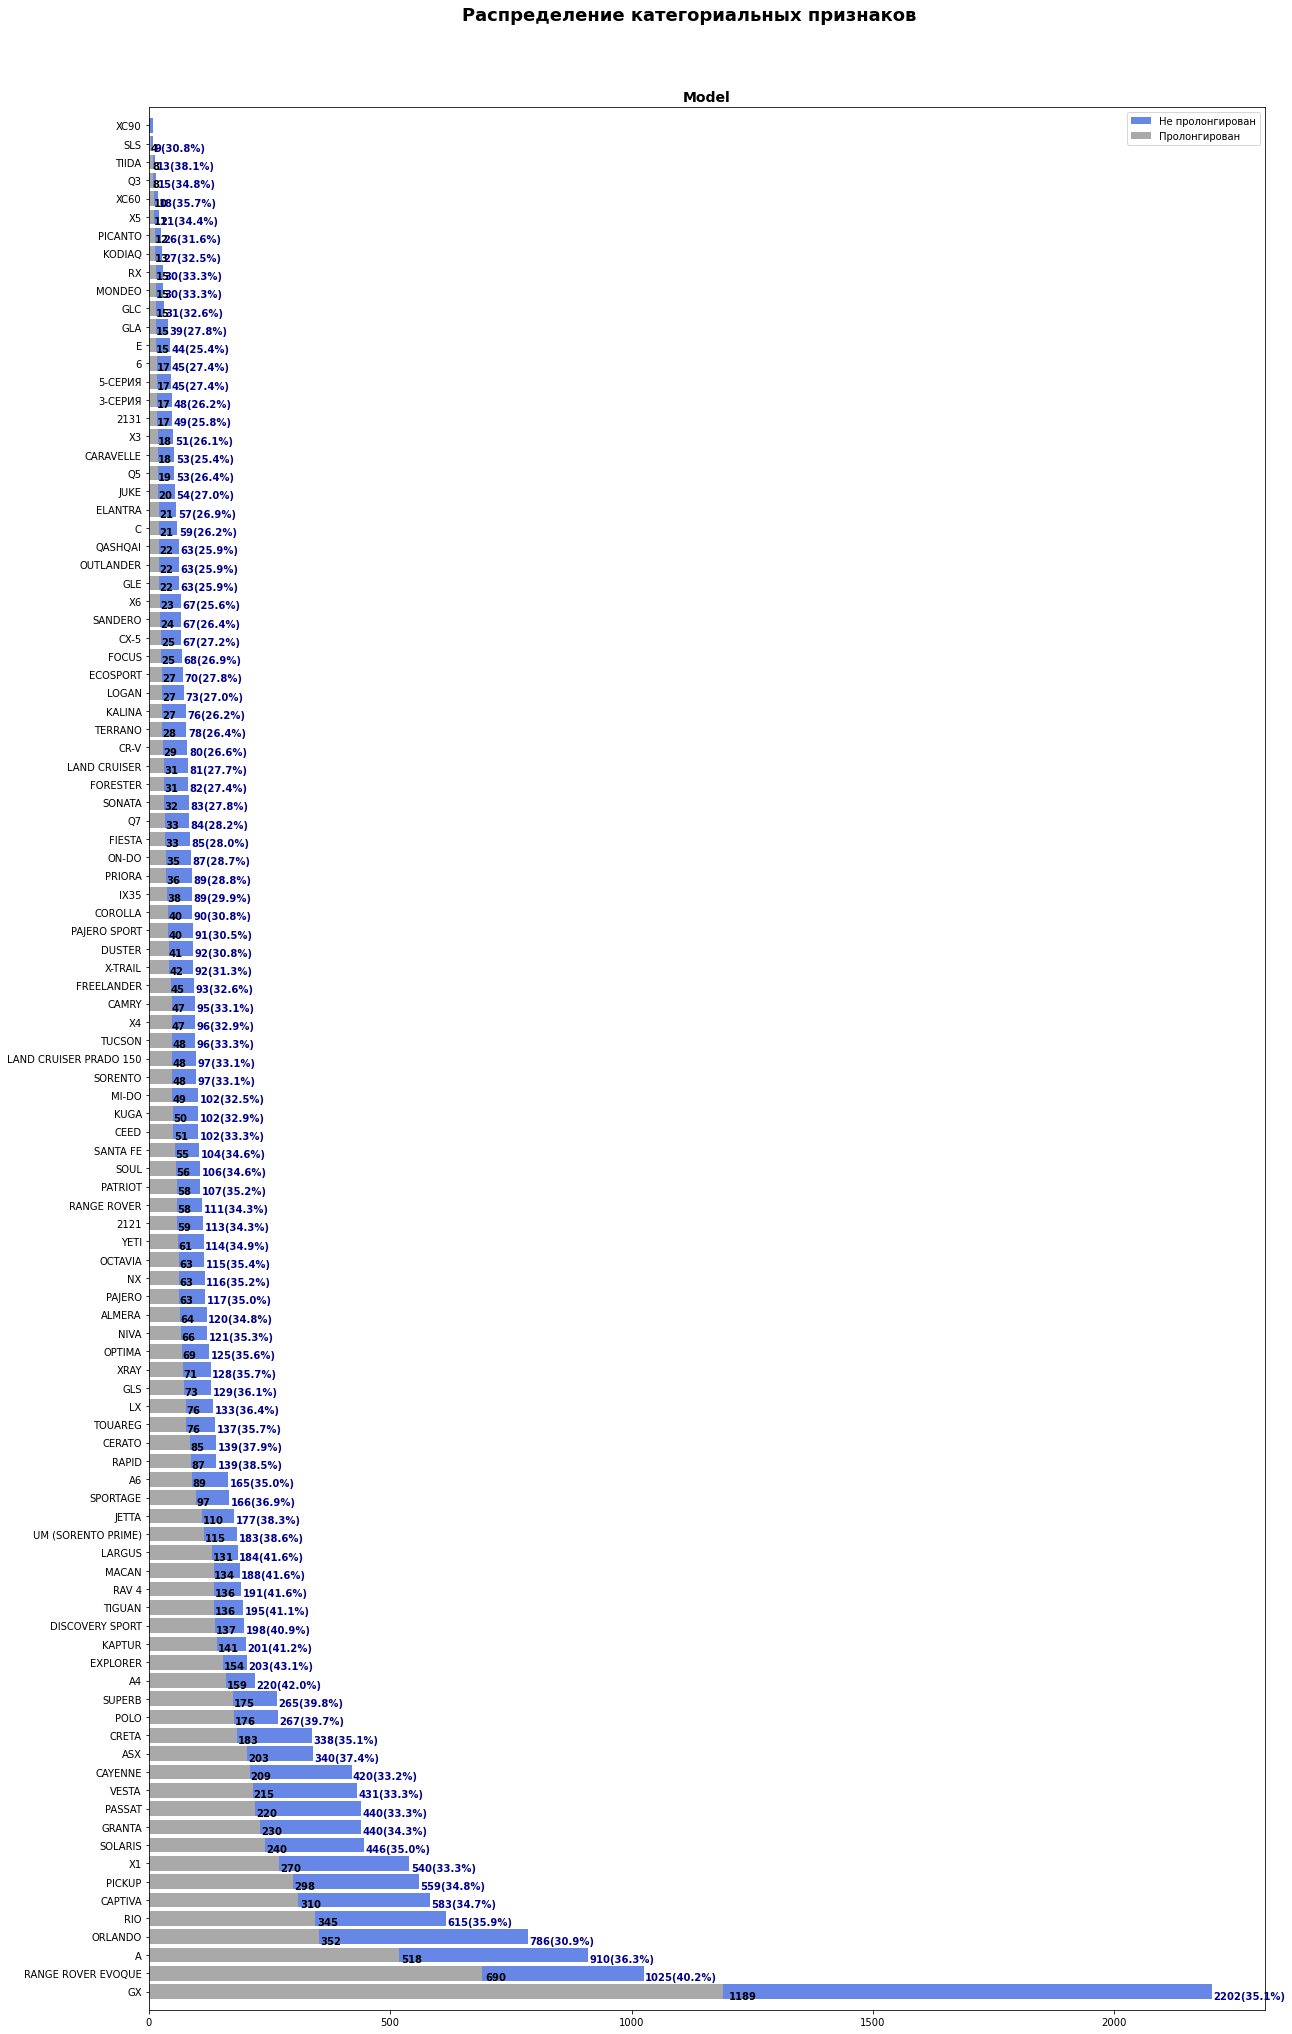

In [32]:
sub_cat = ['Model']
cat_plot(sub_cat,data_0=data_short_0, data_1=data_short_1, height=1, width=1, h_bars=['Model'], figsize=(20, 35))

# Анализ вещественных признаков

<AxesSubplot:>

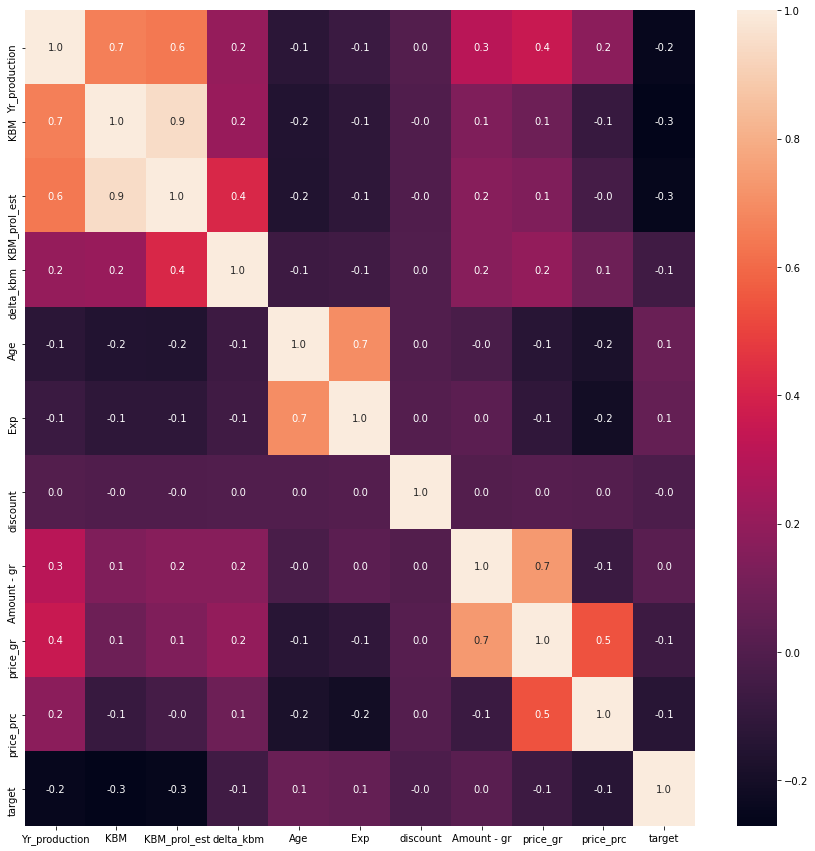

In [101]:
num_cols = list(data_num.columns)


plt.figure(figsize=(15, 15))

sns.heatmap(data_train[num_cols].corr(method='spearman'), annot=True, fmt=".1f")

##### По корреляционной матрице можно судить о  корреляции признаков price_gr и price_prc, Age и Exp, delta_kbm и KBM_prol_est, price_gr и Yr_production, что соответствует характеру этих пар признаков. С целевой переменной наиболее сильно коррелируют признаки KBM и KBM_prol_est.

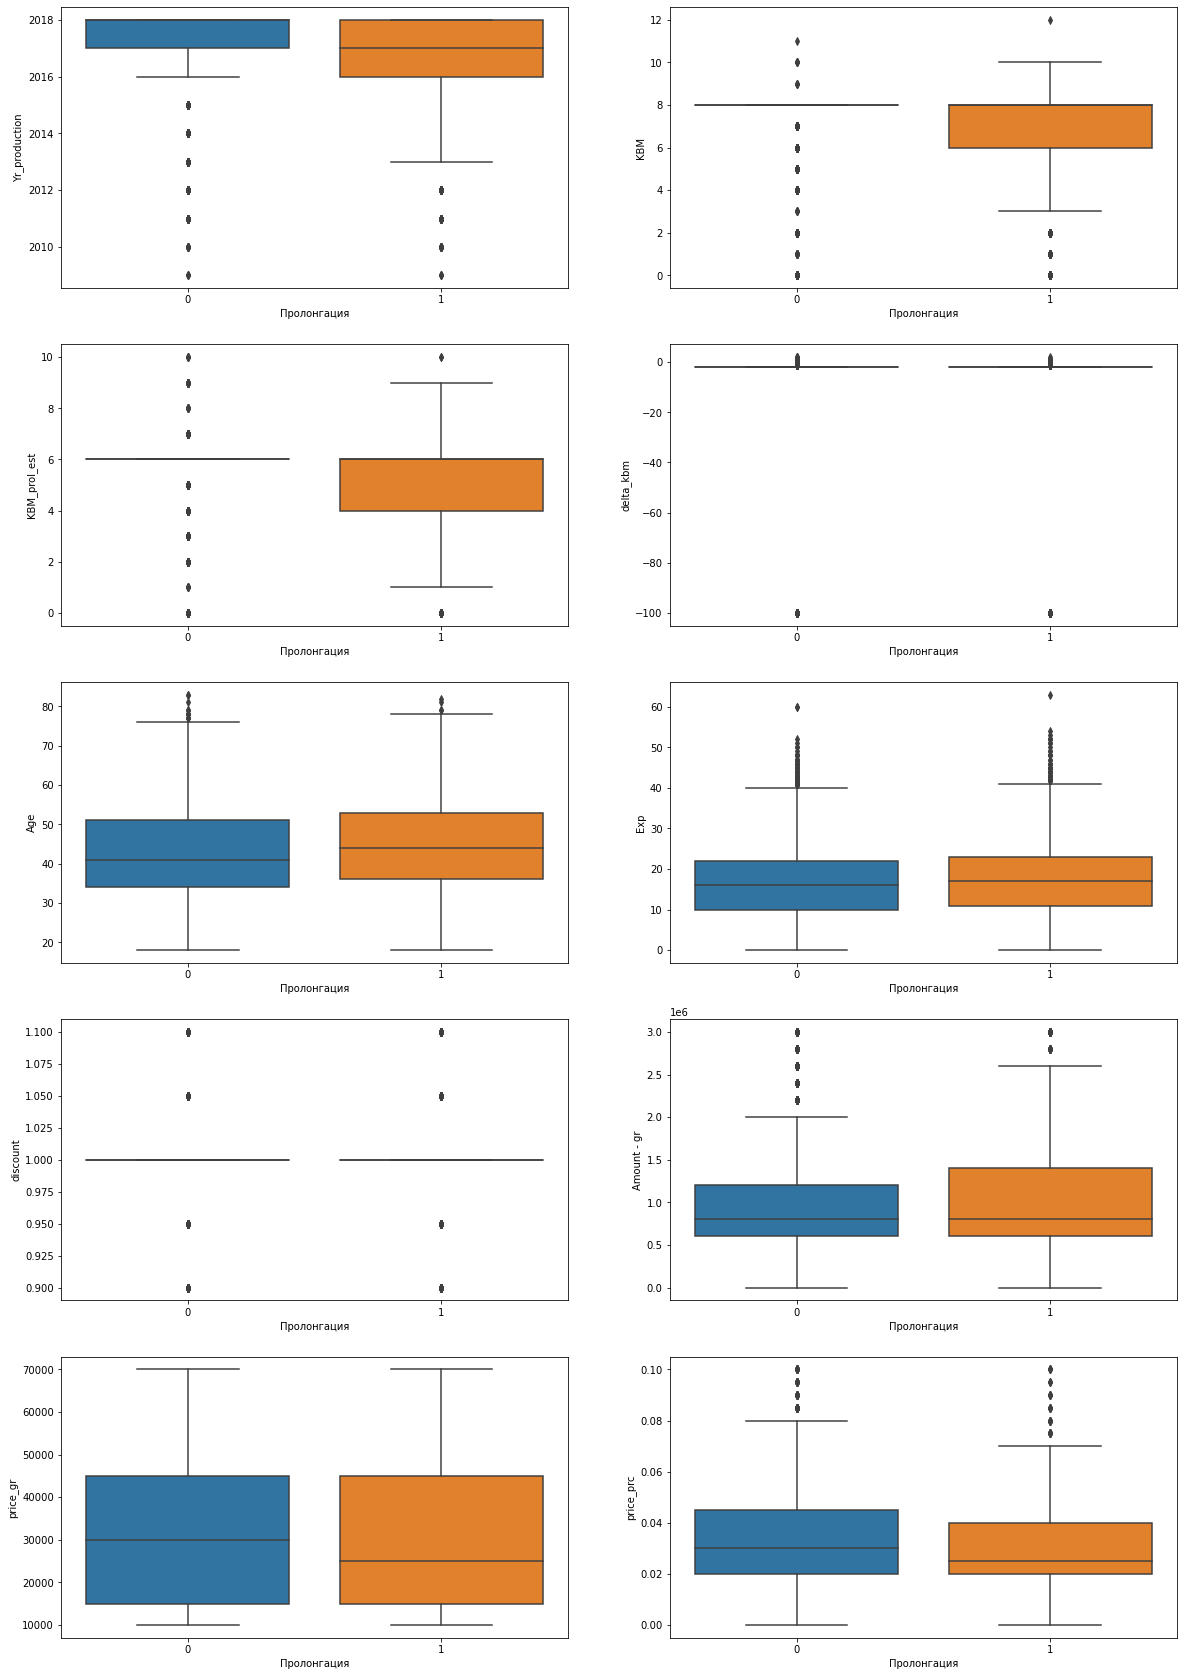

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

for idx, feat in enumerate(num_cols[:-1]):
    sns.boxplot(x='target', y=feat, data=data_train,
                ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel('Пролонгация')
    axes[idx // 2, idx % 2].set_ylabel(feat)

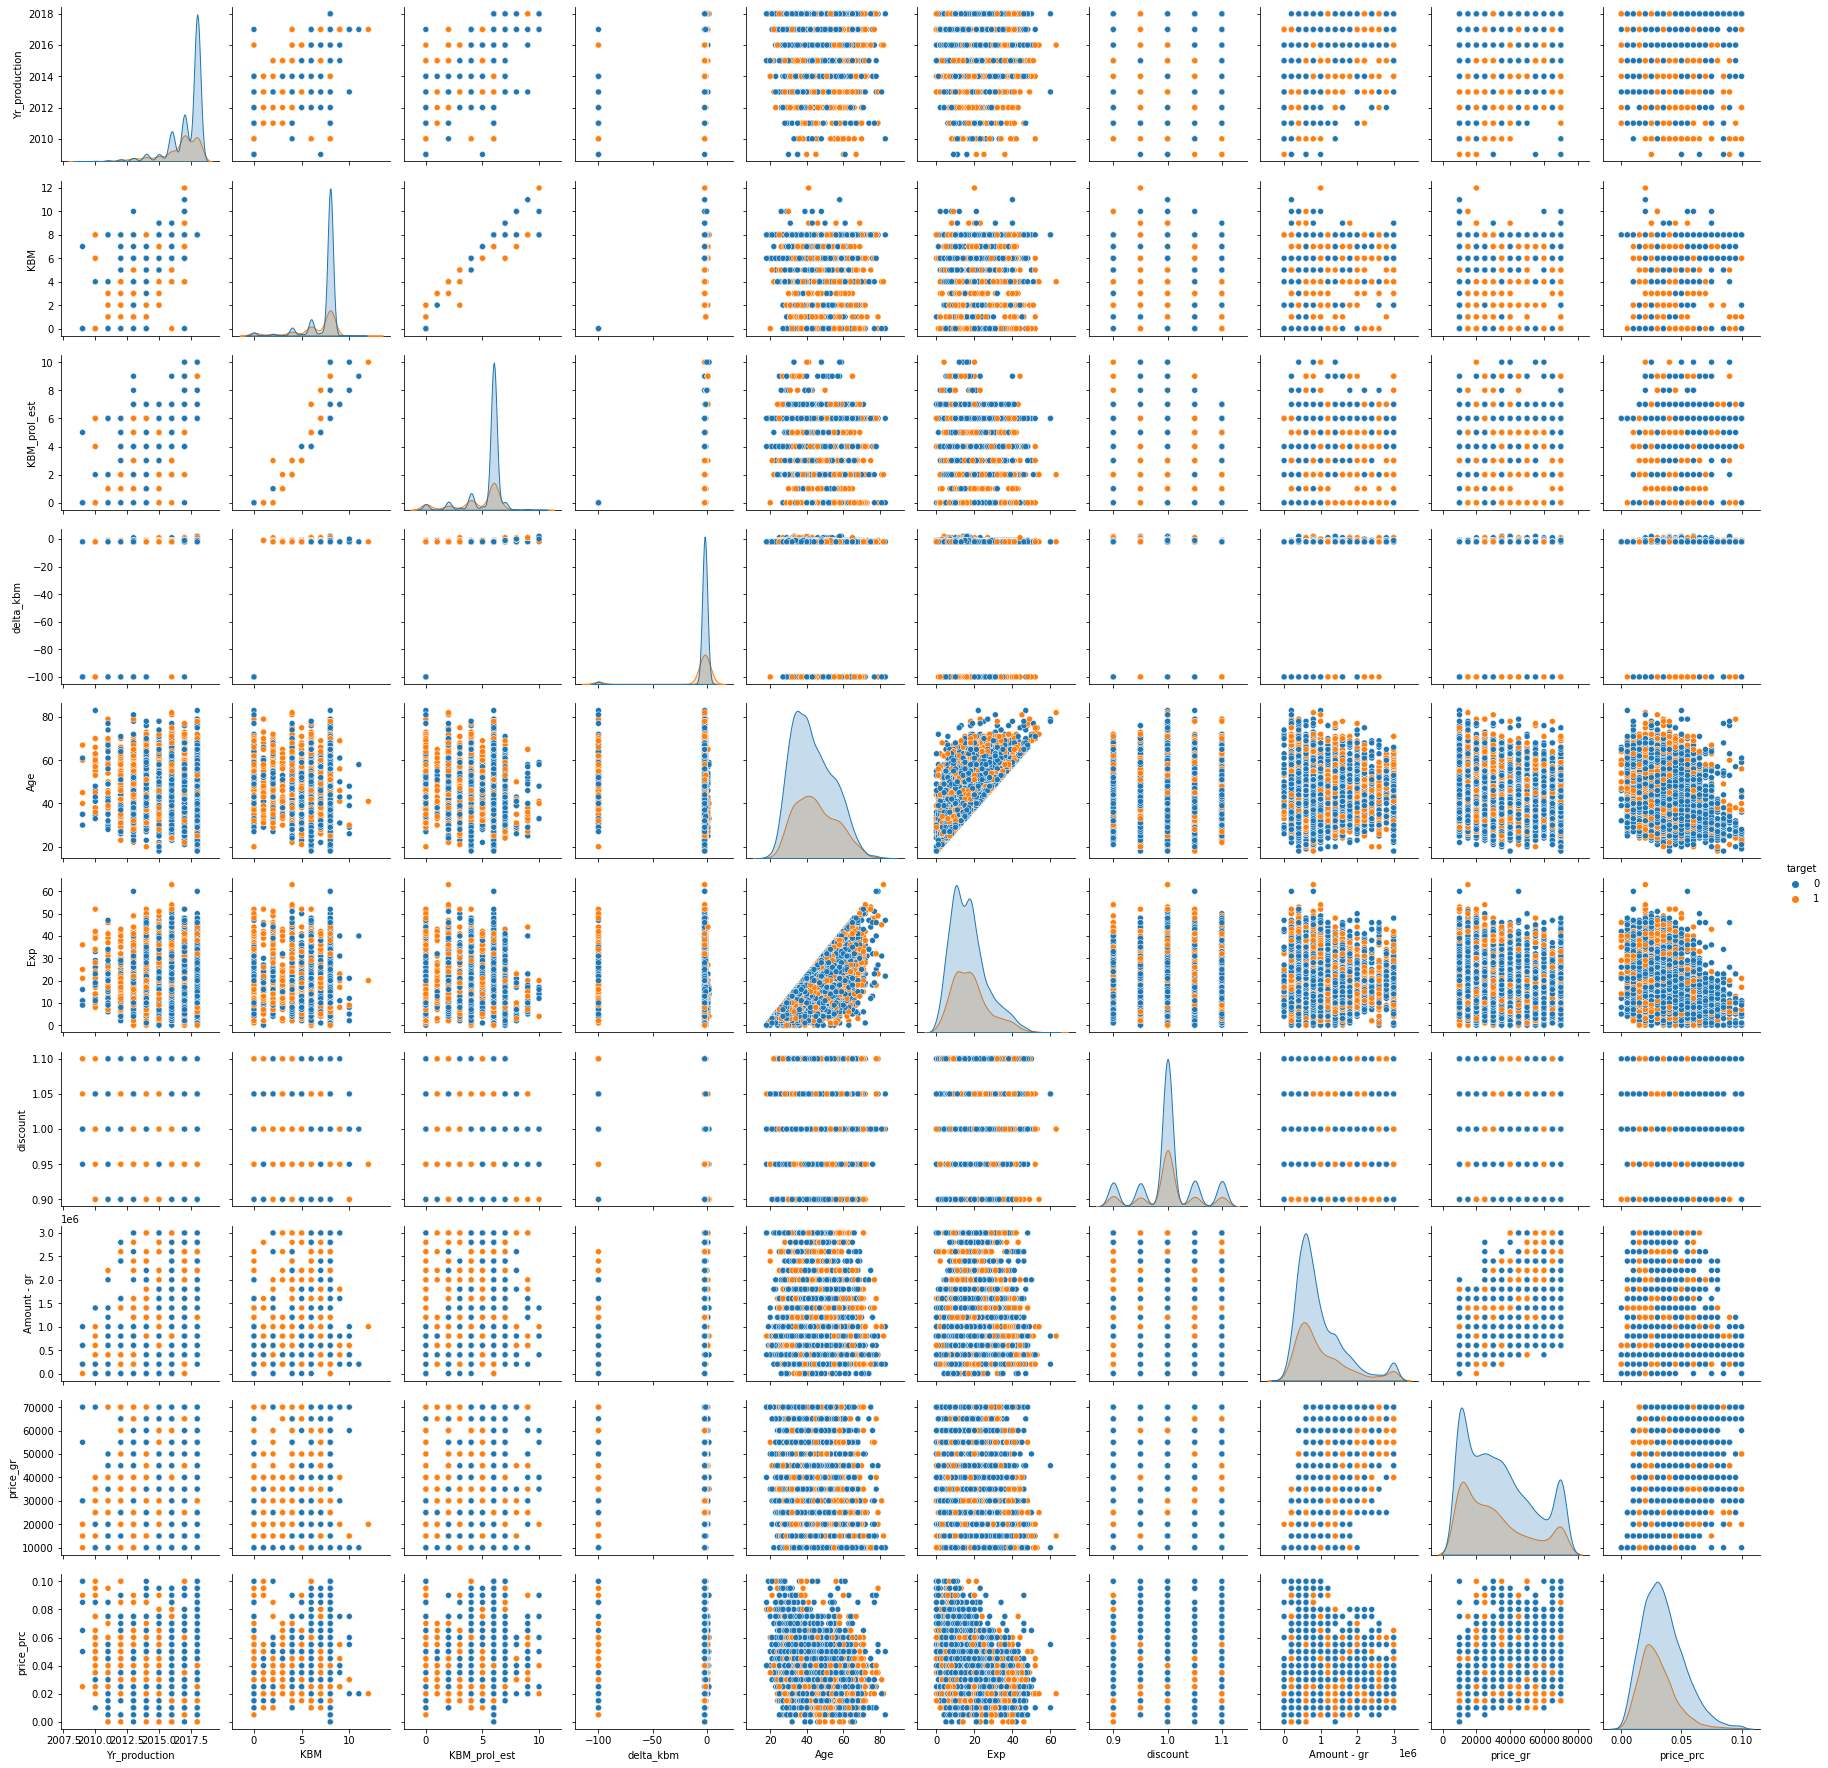

In [36]:
sns.pairplot(data_train[num_cols], hue='target')

##### Исходя из распределений вещественных признаков сильных выбросов в данных не наблюдается

# Построение модели

##### Кодируем категориальные признаки с помощью OHE


In [102]:
dummy_features = pd.get_dummies(data_train[cat_cols], drop_first=True)

num_cols = num_cols[:-1]

X = pd.concat([data_train[num_cols], dummy_features], axis=1)
y = data_train['target']

In [65]:
X.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,Filial_Волгоградский,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
0,2018,8,6,-2,42,24,1.00,1400000,55000,0,...,0,0,0,0,0,0,0,1,0,0
1,2016,8,6,-2,41,4,1.05,200000,10000,0,...,0,0,0,0,1,0,0,1,0,0
2,2018,8,6,-2,49,20,0.95,400000,30000,0,...,0,0,0,0,0,0,0,0,1,0


In [66]:
y.value_counts()

0    5218
1    2370
Name: target, dtype: int64

##### Разделяем данные на обучающую и тестовые выборки

In [103]:
X_train, X_test, y_train, y_test_lr = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=r_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5691, 347)
(1897, 347)
(5691,)


##### Обучим базовую модель

In [104]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred_lr= lr.predict(X_test)
y_score_lr = lr.predict_proba(X_test)[:,1]

In [105]:
print('roc-auc:', roc_auc_score(y_test_lr, y_score_lr))
print('precision:', precision_score(y_test_lr, y_pred_lr))
print('recall:', recall_score(y_test_lr, y_pred_lr))
print('f1:', f1_score(y_test_lr, y_pred_lr))
print('logloss:', log_loss(y_test_lr, y_pred_lr))

roc-auc: 0.6122411204307755
precision: 0.3789571694599628
recall: 0.6875
f1: 0.4885954381752701
logloss: 15.512688887691008


In [106]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test_lr, y_score_lr),
                          precision_score(y_test_lr, y_pred_lr),
                          recall_score(y_test_lr, y_pred_lr),
                          f1_score(y_test_lr, y_pred_lr),
                          log_loss(y_test_lr, y_pred_lr)]

##### Проведем нормализацию данных

In [107]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

##### Проведем подбор гиперпараметров по сетке

In [45]:
estimator = LogisticRegression(max_iter=10000)
params = [{
    'penalty' : ['l1','l2'],
    'solver' : ['liblinear', 'saga'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced', None]},
    
     {'penalty' : ['l2'],
    'solver' : ['newton-cg', 'lbfgs','sag'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
     'class_weight': ['balanced', None]}]

grid_search = GridSearchCV(estimator, params, cv=5, n_jobs=-1, scoring='roc_auc', error_score="raise" )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']}],
             scoring='roc_auc')

##### Выводим полученные параметры и результаты

In [108]:
print(grid_search.best_params_)
print(round(grid_search.best_score_, 4))
best_params = grid_search.best_params_

{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7333


In [110]:
round(grid_search.score(X_test,y_test_lr),4)

0.7567

In [111]:
grid_clf = LogisticRegression(**best_params)
grid_clf.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [112]:
y_pred_clf = grid_clf.predict(X_test)
y_score_clf = grid_clf.predict_proba(X_test)[:,1]

In [114]:
print('roc-auc:', roc_auc_score(y_test_lr, y_score_clf))
print('precision:', precision_score(y_test_lr, y_pred_clf))
print('recall:', recall_score(y_test_lr, y_pred_clf))
print('f1:', f1_score(y_test_lr, y_pred_clf))
print('logloss:', log_loss(y_test_lr, y_pred_clf))

roc-auc: 0.7395813917365641
precision: 0.6018808777429467
recall: 0.32432432432432434
f1: 0.4215148188803513
logloss: 9.595169588292864


In [115]:
metrics['LR with GS/Norm'] = [roc_auc_score(y_test_lr, y_score_clf),
                          precision_score(y_test_lr, y_pred_clf),
                          recall_score(y_test_lr, y_pred_clf),
                          f1_score(y_test_lr, y_pred_clf),
                          log_loss(y_test_lr, y_pred_clf)]

##### Обучим модель на увеличенном датасете

In [139]:
dummy_features = pd.get_dummies(data_short[cat_cols], drop_first=True)

num_cols = list(data_num.columns)[:-1]

X = pd.concat([data_short[num_cols], dummy_features], axis=1)
y = data_short['target']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=r_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(21521, 226)
(7174, 226)
(21521,)


In [93]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [54]:
X_train.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,price_prc,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
3261,-0.302492,-1.287822,-1.408025,0.150398,-0.394274,0.301339,1.876517,0.270881,0.240932,-0.509719,...,1,0,1,0,1,0,0,1,1,0
343,0.266657,-0.327871,-0.395795,0.150398,-0.485542,-1.085158,-0.074285,1.111249,1.186858,-0.132573,...,0,0,1,0,1,0,0,0,1,1
1625,-0.302492,0.632079,0.616434,0.150398,-1.033155,-0.391910,-0.074285,-0.149303,0.240932,0.244573,...,1,0,1,1,0,0,0,0,1,1


In [55]:
estimator = LogisticRegression(max_iter=10000)
params = [{
    'penalty' : ['l1','l2'],
    'solver' : ['liblinear', 'saga'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced', None]},
    
     {'penalty' : ['l2'],
    'solver' : ['newton-cg', 'lbfgs','sag'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
     'class_weight': ['balanced', None]}]

grid_search_short = GridSearchCV(estimator, params, cv=5, n_jobs=-1, scoring='roc_auc', error_score="raise" )
grid_search_short.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']}],
             scoring='roc_auc')

In [152]:
print(grid_search.best_params_)
print(f'Train cv score = {round(grid_search_short.best_score_, 4)}')
print(f'Test cv score = {round(grid_search_short.score(X_test,y_test),4)}')
best_params = grid_search_short.best_params_


{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Train cv score = 0.9422
Test cv score = 0.5216


In [153]:
short_clf = LogisticRegression(**best_params, max_iter=10000)
short_clf.fit(X_train, y_train)
y_pred_sh = short_clf.predict(X_test)
y_score_sh = short_clf.predict_proba(X_test)[:,1]

In [154]:
print('roc-auc:', roc_auc_score(y_test, y_score_sh))
print('precision:', precision_score(y_test, y_pred_sh))
print('recall:', recall_score(y_test, y_pred_sh))
print('f1:', f1_score(y_test, y_pred_sh))
print('logloss:', log_loss(y_test, y_pred_sh))

roc-auc: 0.9423150955507528
precision: 0.7876661742983752
recall: 0.8484486873508353
f1: 0.8169283799310609
logloss: 4.602666574025227


In [97]:
metrics['LR with GS/Norm/OverSampling'] = [roc_auc_score(y_test, y_score_sh),
                          precision_score(y_test, y_pred_sh),
                          recall_score(y_test, y_pred_sh),
                          f1_score(y_test, y_pred_sh),
                          log_loss(y_test, y_pred_sh)]

In [98]:
metrics

,Baseline_LR,LR with GS/Norm,LR with GS/Norm/OverSampling
roc-auc,0.601511,0.745727,0.942636
precision,0.370130,0.622699,0.790637
recall,0.672850,0.342327,0.839698
f1,0.477558,0.441785,0.814429
logloss,15.895042,9.340269,4.631551


##### Построим ROC-AUC для всех моделей

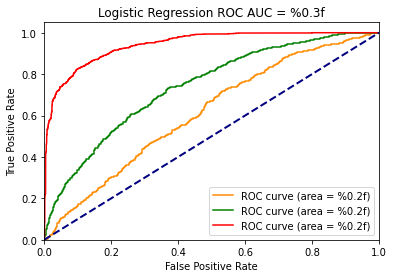

In [116]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_lr, y_score_lr)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_lr, y_score_clf)
fpr_3, tpr_3, tresholds_3 = roc_curve(y_test, y_score_sh)

roc_auc_1 = auc(fpr_1, tpr_1)
roc_auc_2 = auc(fpr_2, tpr_2)
roc_auc_3 = auc(fpr_3, tpr_3)

plt.plot(fpr_1, tpr_1, color='darkorange', label='ROC curve (area = %0.2f)' )
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)')
plt.plot(fpr_3, tpr_3, color='red', label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' )
plt.legend(loc="lower right")
plt.show()

##### Выведем самые большие веса последней модели

In [131]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['importance'] = short_clf.coef_[0]
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp.head(50)

,feature,importance
213,product_Классика,8.544697
214,product_Компакт,7.495894
215,product_Уверенный,6.980774
30,Filial_Челябинский,5.529831
13,Filial_Екатеринбургский,5.441876
29,Filial_Уфимский,4.739295
22,Filial_Пермский,4.664201
18,Filial_Магнитогорский,4.568787
33,passport_region_Белгородская область,4.467234
24,Filial_Самарский,4.276584


##### Как видно 3 самых важных признака - вид продукта, за ним следует филиал обслуживания и некоторые модели автомобилей

# Предсказание и выгрузка результатов

In [132]:
data_test =  data_full[(data_full['target'] == -1)]

In [133]:
dummy_features = pd.get_dummies(data_test[cat_cols], drop_first=True)

num_cols = list(data_num.columns)[:-1]

X = pd.concat([data_test[num_cols], dummy_features], axis=1)

In [134]:
X[num_cols] = scaler.transform(X[num_cols])

In [135]:
X.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,price_prc,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
7598,0.036659,0.49285,0.471141,0.179742,-0.326577,0.290476,-0.016687,0.036271,-0.396908,-0.489654,...,0,0,1,0,0,0,0,1,1,0
7599,-1.251173,0.49285,0.471141,0.179742,1.533747,0.290476,1.982538,0.036271,0.619540,0.394894,...,1,0,1,0,0,1,0,0,1,0
7600,0.680576,0.49285,0.471141,0.179742,0.470704,-0.538924,-1.016299,0.331573,-0.142796,-0.489654,...,0,0,0,0,0,0,0,1,1,0


In [142]:
for column in X.columns:
    if column not in X_train.columns:
        X.drop(column, axis=1, inplace=True)

In [149]:
X

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,price_prc,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
0,2018,8,6,-2,42,24,1.00,1400000,55000,0.040,...,0,0,0,0,0,0,0,1,0,0
1,2016,8,6,-2,41,4,1.05,200000,10000,0.010,...,0,0,0,0,1,0,0,1,0,0
2,2018,8,6,-2,49,20,0.95,400000,30000,0.065,...,0,0,0,0,0,0,0,0,1,0
3,2016,8,6,-2,40,15,1.10,400000,10000,0.020,...,0,1,0,0,1,0,0,1,1,0
4,2018,8,6,-2,58,23,1.00,400000,10000,0.015,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,2014,4,2,-2,39,12,1.00,800000,35000,0.035,...,1,0,1,0,0,1,0,1,1,0
1937,2014,4,2,-2,39,12,1.00,800000,35000,0.035,...,1,0,1,0,0,1,0,1,1,0
1937,2014,4,2,-2,39,12,1.00,800000,35000,0.035,...,1,0,1,0,0,1,0,1,1,0
1937,2014,4,2,-2,39,12,1.00,800000,35000,0.035,...,1,0,1,0,0,1,0,1,1,0


In [155]:
y_score_final = pd.DataFrame(short_clf.predict_proba(X)[:,1])

In [157]:
y_score_final.to_csv('./Petrenko_result.csv', index=False)